#Классификация текстов с помощью BERT

Задача: при загрузке прайс-листов в сервис необходимо автоматически распределять товары по нужным категориям.

Для реализации этого наилучшим образом подходит задача классификации текстов. Классификатор построим на предобученной модели BERT. Так как тексты у нас преимущественно на русском языке, возьмём модель **RuBert** от DeepPavlov. Для реализации всего процесса будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от huggingface, которая позволяет быстро реализовать тот или иной вид Трансформера.

Для дообучения модели предварительно был скачан датасет с Леруа, содержащий названия товаров и категорию, к которой они относятся. Все цифры из текста были удалены.

Трансформер - модель нейросети, использующая внутреннюю память для выявления и запоминания внутренних связей между словами. При этом исследования показали, что в отличие от моделей типа RNN или CNN, Трансформер может запоминать и довольно-таки далёкие связи между словами.

BERT - разновидность Трансформера, имеющая 2 принципиальных отличия.

В классическом Трансформере для языкового моделирования импользуется маска для последовательного "угадывания" слов: слово предсказываается из контекста, идущего слева он маскированного слова, в Берте же слово маскируется случайным образом.

Вторая особенность - Берт принимает на вход 2 предложения - для того, чтобы понимать взаимосвязанные предложения. В решении нашей задачи это не важно, но это нужно помнить при подготовке текста перед подачей его Берту.

Дополнительно, Берт использует собственную разметку токенов. Мы будем использовать уже имеющийся предобученный токенизатор.

Токенизатор разбивает слова на подслова, благодаря чему обученная модель сможет хорошо понимать слова с опечатками и ошибками, а также сможет обрабатывать возможные новые слова. (Более ранние модели дистрибутивной семантики, например, word2vec этого сделать не могли).

Использование предобученных языковых моделей показало очень хорошие результаты для решения большого количества задач при работе с текстами. Языковые модели обучаются на очень большом количестве текстов различной тематики, запоминая особенности языка и взаимосвязи между словами. Потом предобученную модель можно использовать на своём, небольшом датасете для решения конкретной задачи. При этом, нам уже не требуется больших вычислительных ресурсов для получения качественного результата, что значительно ускоряет и удешевляет процесс разработки конечного продукта. Разработчики Берта рекомендуют дообучать предобученную модель совсем немного: достаточно 2 - 4 эпох для получения качественного результата.

## Подключение библиотек

In [0]:
!git clone https://github.com/blanchefort/utils.git
!pip install transformers

In [0]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from utils.ml.train_model import init_random_seed
from utils.ml.visualize import config_my_plotting

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
init_random_seed(42)
config_my_plotting()
# Узнаем, что за карта
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


<Figure size 1200x600 with 0 Axes>

# Подготовка датасета

В качестве основного фреймворка для обучения модели мы используем Pytorch, поэтому будем пользоваться его инструментами формирования датасета и подачи батчей модели.

Pytorch предоставляет возможность использовать различные виды датасетов. Так как наша выборка небольшая, мы сразу загрузим её в память и преобразуем в тензоры, которые будут подаваться модели.

In [0]:
df = pd.read_csv('/content/drive/My Drive/colab_data/leroymerlin/to_classifier.csv')
# Размер нашей выборки
df.shape

(264587, 2)

In [0]:
df.sample(5)

,category_1,name
49405,Инструменты,Рубанок для газобетона
136867,Сад,Пила электрическая цепная Калибр ЭПЦ- / ш...
114423,Водоснабжение,Гель Сантехмастер г цвет зелёный
190705,Скобяные изделия,Карабин усиленный Standers х мм
177073,Скобяные изделия,Цифра « » самоклеящаяся х мм пластик цвет ...


In [0]:
# категории товаров будут нашими метками
df.category_1.unique()

array(['Стройматериалы', 'Столярные изделия', 'Окна и двери',
       'Электротовары', 'Инструменты', 'Напольные покрытия', 'Плитка',
       'Сантехника', 'Водоснабжение', 'Сад', 'Скобяные изделия', 'Краски',
       'Декор', 'Освещение', 'Хранение', 'Кухни'], dtype=object)

In [0]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.category_1.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится 
# после обучения для большей наглядности, чтобы видеть, к какой категории товар 
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.category_1.unique())}

In [0]:
category_index

{'Водоснабжение': 8,
 'Декор': 12,
 'Инструменты': 4,
 'Краски': 11,
 'Кухни': 15,
 'Напольные покрытия': 5,
 'Окна и двери': 2,
 'Освещение': 13,
 'Плитка': 6,
 'Сад': 9,
 'Сантехника': 7,
 'Скобяные изделия': 10,
 'Столярные изделия': 1,
 'Стройматериалы': 0,
 'Хранение': 14,
 'Электротовары': 3}

In [0]:
# Переведём все метки датасета в числа
sentences = df.name.values
labels = [category_index[i] for i in df.category_1.values]

In [0]:
# Каждому предложению (названию товара) теперь соответсвует не название категории, а её индекс:
sentences[22], labels[22]

('Шпаклёвка полимерная финишная Weber Vetonit KR    кг', 0)

In [0]:
# Проверим, что все данные корректны
assert len(sentences) == len(labels) == df.shape[0]

# Токенизация

Теперь подготовленный датасет нужно токенизировать. Для этого мы воспользуемся уже предобученным токенизатором, идущим вместе с моделью от DeepPavlov.

Каждый сэмпл мы приведём к виду, который требуется Берту, затем разобъём выборку на обучающую и отложенную, для последующей проверки качества.

Специальные токены Берта:

* `[CLS]` - начало последовательности
* `[SEP]` - разделение двух предложений

Мы будем обрамлять наши сэмплы этими токенами.


In [0]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [0]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

In [0]:
len(train_sentences), len(test_sentences)

(263264, 1323)

Теперь загрузим наш токенизатор. Он идёт вместе с предобученной моделью [RuBert от DeepPavlov](https://huggingface.co/DeepPavlov/rubert-base-cased).

Загружать будем с помощью универсального метода Pytorch `torch.hub.load`.

In [0]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased')

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [0]:
# Токенизируем нашу обучающую выборку
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [0]:
# Посмотрим, что получилось
# Сомволы номеров отмечают то, что данный токен - продолжение слова
print(tokenized_texts[42])

['[CLS]', 'пил', '##а', 'сабель', '##ная', 'pat', '##rio', '##t', 'r', '##s', '[SEP]']


In [0]:
# ииндексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Теперь нам нужно выбрать размер входной последовательности, подаваемой нейросети. Он должен быть фиксированным, но наши сэмплы имеют различную длину.

Поэтому посмотрим на распределение количества токенов в сэмплах и попытаемся определить оптимальный размер. В нашей задаче используются короткие последовательности, поэтому мы можем брать максимальную длину, в других же задачах это может быть критично - мы должны учитывать контекст по максимуми, при этом нужно учитывать, хватит ли машине памяти для обработки последовательностей большого размера.

Выбрав размер, мы приведём все сэмплы к единому виду: последовательности большого размера будут образаны, последовательности малого размера дополнятся паддингами - специальными нулевыми токенами.

(array([ 7489., 36332., 90491., 64128., 38122., 20172.,  4029.,  1959.,
          378.,   164.]),
 array([ 4. ,  7.4, 10.8, 14.2, 17.6, 21. , 24.4, 27.8, 31.2, 34.6, 38. ]),
 <a list of 10 Patch objects>)

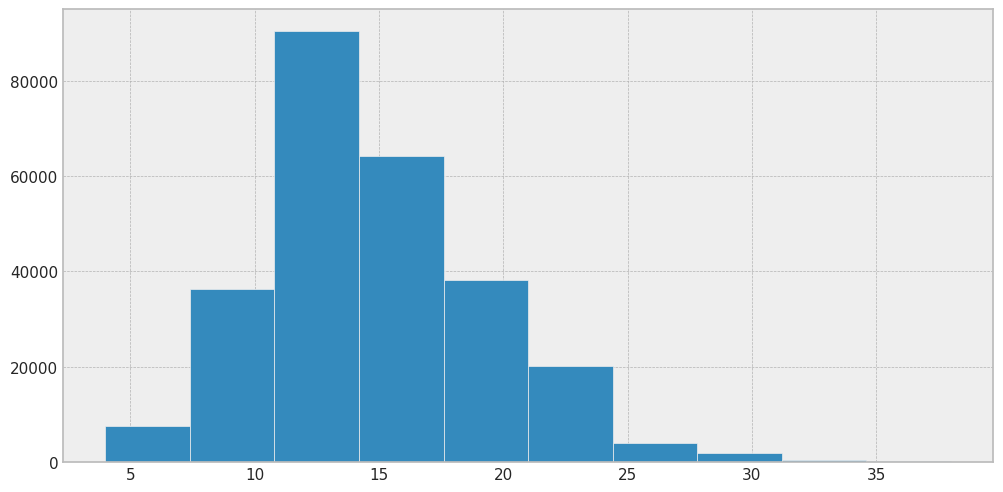

In [0]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [0]:
# Выравниваем датасет. Возьмём размер, равный 24
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)

In [0]:
# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 24 токенов, поэтому в конец был добавлен паддинг
input_ids[42]

array([  101, 12677,   626, 98270,  2630, 20706, 12525,   271,   266,
         269,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [0]:
# Создадим маску внимания для каждого сэмпла нашей обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [0]:
print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [0]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

Теперь разобъём наш трейн на собственно обучающую выборку и валидационную - для того, чтобы проверять качество в ходе дообучения модели: нужно разделить как последовательности, так и их маски.

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [0]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

## Инициализация DataLoader'ов

Переведём все наши данные в тип Тензор, с которым работает Pytorch и инициализируем уже готовый DataLoader из этой библиотеки.

In [0]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

В ходе экспериментов можно подобрать разные размеры батча. Но нужно учитывать то, что при больших размерах батча на видеокарте может не хватить памяти, при слишком же малых размерах батча обучение будет нестабильным. Разработчики Берта рекомендуют брать батч размером 32, мы же возьмём 64, так как наши последовательности не очень большие.

In [0]:
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=64
)

# Дообучение

Загружаем веса предобученной модели и запускаем процесс дообучения на наших данных.

Так как в результате мы хотим получить не языковую модель, а мультиклассовый классификатор, укажем это при настройках.

В библиотеке Transformers уже имплементированы классы для различных задач. Нам понадобится `AutoModelForSequenceClassification`.

Использовав этот класс, мы возьмём предобученный Берт, добавив ему на выход один полносвязный слой, который и будет решать нашу задачу классификации. По умолчанию обёртка `AutoModelForSequenceClassification` (или `BertForSequenceClassification`) использует бинарную классификацию. Нам же нужна мультиклассовая, поэтому укажем это в конфигурации.

In [0]:
config = AutoConfig.from_pretrained('DeepPavlov/rubert-base-cased',
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [0]:
# Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', config=config)

In [0]:
# Отправим на видеокарту, заодно посмотрим архитектуру нашего Берта
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Видим, что к выходу Берта был добавлен слой:

```(classifier): Linear(in_features=768, out_features=16, bias=True)```

На выходе получим 16 вероятностей принадлежности текста той или иной метке.

In [0]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [0]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный 
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

Как говорилось выше, для получения хорошего результата достаточно 2 - 4 эпох. Но даже один прогон покажет хороший результат - для нашего датасета и задачи это именно так.

In [0]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

********************
Лосс на обучении: 0.28854785296125846
CPU times: user 7min 20s, sys: 3min 9s, total: 10min 30s
Wall time: 10min 31s


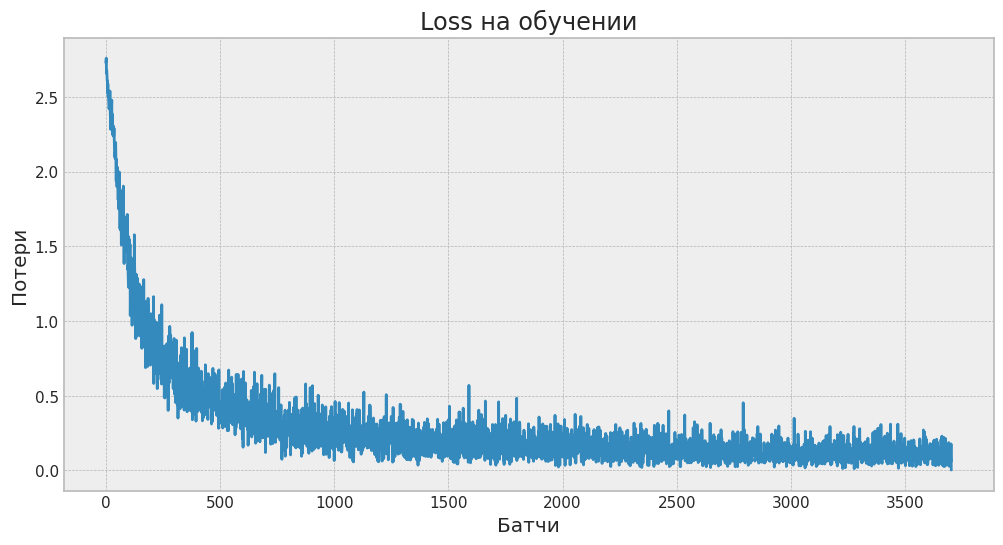

In [0]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

Как видим, модель обучилась достаточно быстро, далее идут лишь флуктуации без улучшений качества.



# Валидация

Проверим работу модели на отложенной выборке.

In [0]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


Посмотрим на качество нашей модели по каждой из категорий. Как видно, при определении каждой из категорий, наша модель справляется сравнительно хорошо. И это даже при том, что мы использовали несбалансированную выборку.

In [0]:
print(classification_report(valid_labels, valid_preds, target_names=category_index_reverce.values()))

                    precision    recall  f1-score   support

    Стройматериалы       0.99      0.96      0.97      1340
 Столярные изделия       1.00      1.00      1.00       263
      Окна и двери       1.00      0.89      0.94        65
     Электротовары       0.96      0.98      0.97      1997
       Инструменты       0.95      0.98      0.96      3050
Напольные покрытия       0.97      0.79      0.87       243
            Плитка       0.92      0.77      0.83       239
        Сантехника       0.97      0.99      0.98      3065
     Водоснабжение       0.99      0.98      0.98      2382
               Сад       0.96      0.99      0.98      4915
  Скобяные изделия       0.98      0.96      0.97      2356
            Краски       0.96      0.95      0.95      1526
             Декор       0.93      0.93      0.93      2994
         Освещение       0.94      0.82      0.87       841
          Хранение       0.96      0.86      0.91       655
             Кухни       0.95      0.89

# Сохранение и загрузка дообученной модели

Для сохранения модели предоставляемыми библиотекой средствами нужно укать путь к папке. Сохраним веса модели и токенизатор.

In [0]:
model.save_pretrained('/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model2/')
tokenizer.save_pretrained('/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model2/')

('/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model2/vocab.txt',
 '/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model2/special_tokens_map.json',
 '/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model2/added_tokens.json')

Теперь попробуем загрузить модель из сохранённого состояния. Загрузим конфигруацию, токенизатор и веса модели.

In [0]:
# config
config = AutoConfig.from_pretrained('/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/My Drive/colab_data/leroymerlin/model/BERT_model', config=config)

С помощью загруженной модели можно определять классы товаров уже на  CPU

In [0]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [0]:
%%time

model.to('cpu')
model.eval()

# Выберем несколько случайных названий товаров
skus = [randint(1, len(df)) for p in range(0, 10)]
for sku in skus:
    ground_truth = df.iloc[sku]['category_1']
    sku_title = df.iloc[sku]['name']
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)

    print(f'Наименование товара: {sku_title}')
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')
    print(f'Истинная категория: {ground_truth}')
    print()

Наименование товара: Шпильки для пневмостеплера  . х   мм     шт.
Предсказанная категория: Инструменты
Истинная категория: Инструменты

Наименование товара: Уголок внутренний HAUBERK терракотовый
Предсказанная категория: Стройматериалы
Истинная категория: Стройматериалы

Наименование товара: Нож для триммера   лезвия    x  .  мм, толщина  .  мм
Предсказанная категория: Сад
Истинная категория: Сад

Наименование товара: Фигура садовая «Пёс с верёвкой»    см
Предсказанная категория: Сад
Истинная категория: Сад

Наименование товара: Отражатель для полотенцесушителя неглубокий, разъемный,  ", хромированная латунь
Предсказанная категория: Водоснабжение
Истинная категория: Водоснабжение

Наименование товара: Ёршик подвесной для унитаза «  », стекло, цвет хром
Предсказанная категория: Сантехника
Истинная категория: Сантехника

Наименование товара: Перчатки с плотным обливом,    г
Предсказанная категория: Стройматериалы
Истинная категория: Инструменты

Наименование товара: Клещи-плиткорез Dexte